# Analyze sea-level predictions for Greenland by ISMIP6 and Aschwanden et al (2019) [AS19]

In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

In [2]:
import numpy as np
import os
import pylab as plt
import pandas as pd
import seaborn as sns
import scipy

import matplotlib.lines as mlines
import matplotlib as mpl
import matplotlib.cm as cmx
import matplotlib.colors as colors

from utilities.data_loader import load_imbie, load_mouginot, load_grace, load_ismip6
from utilities.helper import hist_start, hist_end, proj_start, proj_end, secpera

## Plotting helpers

In [3]:
fontsize = 8
lw = 0.65
aspect_ratio = 0.35
markersize = 2

params = {
    "axes.linewidth": 0.25,
    "lines.linewidth": lw,
    "axes.labelsize": fontsize,
    "font.size": fontsize,
    "xtick.direction": "in",
    "xtick.labelsize": fontsize,
    "xtick.major.size": 2.5,
    "xtick.major.width": 0.25,
    "ytick.direction": "in",
    "ytick.labelsize": fontsize,
    "ytick.major.size": 2.5,
    "ytick.major.width": 0.25,
    "legend.fontsize": fontsize,
    "lines.markersize": markersize,
    "font.size": fontsize,
}

plt.rcParams.update(params)


grace_signal_lw = 0.75
mouginot_signal_lw = 0.75
imbie_signal_lw = 0.75
simulated_signal_lw = 0.15
grace_signal_color = "#084594"
grace_sigma_color = "#9ecae1"
mouginot_signal_color = "#a63603"
mouginot_sigma_color = "#fdbe85"
imbie_signal_color = "#005a32"
imbie_sigma_color = "#a1d99b"
simulated_signal_color = "0.7"

gt2cmSLE = 1.0 / 362.5 / 10.0

rcp_list = ["26", "85"]
rcp_dict = {"26": "RCP 2.6", "45": "RCP 4.5", "85": "RCP 8.5", "CTRL": "CTRL"}
rcp_col_dict = {"CTRL": "k", "85": "#990002", "45": "#5492CD", "26": "#003466"}
rcp_shade_col_dict = {"CTRL": "k", "85": "#F4A582", "45": "#92C5DE", "26": "#4393C3"}
model_ls_dict = {"Model Uncertainty (ISMIP6)": "solid", "Parametric Uncertainty (AS19)": "dashed"}


def set_size(w, h, ax=None):
    """ w, h: width, height in inches """

    if not ax:
        ax = plt.gca()
    l = ax.figure.subplotpars.left
    r = ax.figure.subplotpars.right
    t = ax.figure.subplotpars.top
    b = ax.figure.subplotpars.bottom
    figw = float(w) / (r - l)
    figh = float(h) / (t - b)
    ax.figure.set_size_inches(figw, figh)



## Load ISMIP6 Greenland projections

In [4]:
ismip6 = load_ismip6()

## ISMIP6 in numbers

In [5]:
ng = len(ismip6.groupby(by="Group").mean())
nm = len(ismip6.groupby(by="Model").mean())
ne = len(ismip6.groupby(by="Exp").mean())

print(f"Number of modeling groups participated: {ng}")
print(f"Number of ice sheet model configurations used: {nm}")
print(f"Number of experiments: {ne}")

Number of modeling groups participated: 13
Number of ice sheet model configurations used: 18
Number of experiments: 9


## Load Observations

In [6]:
grace = load_grace()
mou19 = load_mouginot()
imbie = load_imbie()

## Plot function to reproduce Figure 1 in Aschwanden et al (2021)

In [7]:
def plot_historical(out_filename, df, grace, mou19, imbie):
    """
    Plot historical simulations and observations.
    """

    def plot_signal(g):
        m_df = g[-1]
        x = m_df["Year"]
        y = m_df["Cumulative ice sheet mass change (Gt)"]

        return ax.plot(x, y, color=simulated_signal_color, linewidth=simulated_signal_lw)

    xmin = 2000
    xmax = 2025
    ymin = -3000
    ymax = 4000

    fig = plt.figure(num="historical", clear=True)
    ax = fig.add_subplot(111)

    
    [plot_signal(g) for g in df.groupby(by=["Group", "Model", "Exp"])]

    ismip6_mean = df.groupby(by="Year").mean()
    ismip6_std = df.groupby(by="Year").std()
    ismip6_low = df.groupby(by="Year").quantile(0.05)
    ismip6_high = df.groupby(by="Year").quantile(0.95)


    ismip6_ci = ax.fill_between(
        ismip6_mean.index,
        ismip6_low["Cumulative ice sheet mass change (Gt)"],
        ismip6_high["Cumulative ice sheet mass change (Gt)"],
        color="0.0",
        alpha=0.30,
        linewidth=0.0,
        zorder=10,
        label="Simulated (ISMIP6) 90% c.i."
    )


    # Plot GRACE
    ax.fill_between(
        mou19["Year"],
        (1 - 0.057) * mou19["Cumulative ice sheet mass change (Gt)"],
        (1 + 0.057) * mou19["Cumulative ice sheet mass change (Gt)"],
        color=mouginot_sigma_color,
        alpha=0.5,
        linewidth=0,
    )
    mou19_line = ax.plot(
        mou19["Year"],
        mou19["Cumulative ice sheet mass change (Gt)"],
        "-",
        color=mouginot_signal_color,
        linewidth=mouginot_signal_lw,
        label="Observed (Mouginot)",
    )

    ax.fill_between(
        imbie["Year"],
        imbie["Cumulative ice sheet mass change (Gt)"]
        - 1 * imbie["Cumulative ice sheet mass change uncertainty (Gt)"],
        imbie["Cumulative ice sheet mass change (Gt)"]
        + 1 * imbie["Cumulative ice sheet mass change uncertainty (Gt)"],
        color=imbie_sigma_color,
        alpha=0.5,
        linewidth=0,
    )
    imbie_line = ax.plot(
        imbie["Year"],
        imbie["Cumulative ice sheet mass change (Gt)"],
        "-",
        color=imbie_signal_color,
        linewidth=imbie_signal_lw,
        label="Observed (IMBIE)",
    )

    ax.fill_between(
        grace["Year"],
        grace["Cumulative ice sheet mass change (Gt)"]
        - 1 * grace["Cumulative ice sheet mass change uncertainty (Gt)"],
        grace["Cumulative ice sheet mass change (Gt)"]
        + 1 * grace["Cumulative ice sheet mass change uncertainty (Gt)"],
        color=grace_sigma_color,
        alpha=0.5,
        linewidth=0,
    )
    grace_line = ax.plot(
        grace["Year"],
        grace["Cumulative ice sheet mass change (Gt)"],
        "-",
        color=grace_signal_color,
        linewidth=grace_signal_lw,
        label="Observed (GRACE)",
    )
    ax.axvline(proj_start, color="k", linestyle="dashed", linewidth=grace_signal_lw)
    ax.axhline(0, color="k", linestyle="dotted", linewidth=grace_signal_lw)
    ax.text(2014.75, 3000, "Historical Period", ha="right")
    ax.text(2015.25, 3000, "Projection Period", ha="left")

    model_line = mlines.Line2D([], [], color=simulated_signal_color, linewidth=simulated_signal_lw, label="Simulated (ISMIP6)")

    legend = ax.legend(handles=[grace_line[0], mou19_line[0], imbie_line[0], model_line, ismip6_ci], loc="lower left")
    legend.get_frame().set_linewidth(0.0)
    legend.get_frame().set_alpha(0.0)

    ax.set_xlabel("Year")
    ax.set_ylabel(f"Cumulative mass change\nsince {proj_start} (Gt)")

    ax.set_xlim(xmin, xmax)
    ax.set_ylim(ymin, ymax)
    ax_sle = ax.twinx()
    ax_sle.set_ylabel(f"Contribution to sea-level \nsince {proj_start} (cm SLE)")
    ax_sle.set_ylim(-ymin * gt2cmSLE, -ymax * gt2cmSLE)

    set_size(5, 2.5)

    fig.savefig(out_filename, bbox_inches="tight")


## Plot the historical simulations along side observations

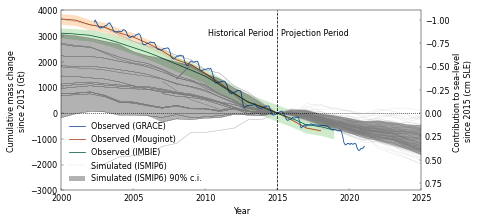

In [8]:
historical_filename = "GRIS_historical.pdf"
plot_historical(historical_filename, ismip6, grace, mou19, imbie)


Unfortunately, most simulations underestimate recent (2008--2020) mass loss. Indeed, the observed record of mass loss lies beyond the 95th percentile of the ISMIP6 experiments. Underestimating recent mass loss likely translates into underestimating mass loss at 2100 as well.  That observations and the ensemble are disjoint implies that model uncertainty is underestimated both now and in the future. 

## Comparison between model and parametric uncertainty

Let us now compare model uncertainty and parametric uncertainty. Here we will use the 500 member ensemble of Aschwanden et al. (2019) [AS19]. We start by loading the AS19 data set.

In [9]:
as19_norm = pd.read_csv("as19/aschwanden_et_al_2019_les_2015_norm.csv.gz")
as19_norm["SLE (cm)"] = -as19_norm["Mass (Gt)"] / 362.5 / 10
as19_norm = as19_norm.astype({"RCP": int, "Experiment": int})

samples_file = "lhs_samples/lhs_samples_500.csv"
samples = pd.read_csv(samples_file).rename(columns={"id": "Experiment"})

as19_norm = pd.merge(as19_norm, samples, on="Experiment")


In [10]:
print("Inter-quartile range (IQR):\n\n")

as19_2100 = as19_norm[as19_norm["Year"] == 2100]
ismip6_2100 = ismip6[ismip6["Year"] == 2100]
model_df_dict = {"Model Uncertainty (ISMIP6)": ismip6_2100, "Parametric Uncertainty (AS19)": as19_2100}

fig = plt.figure(num="kde", clear=True)
ax = fig.add_subplot(111)

for l, df in model_df_dict.items():
    for rcp in rcp_list:
        s_df = df[df["RCP"] == rcp]
        color = rcp_col_dict[str(rcp)]
        sns.kdeplot(data=s_df, x="SLE (cm)", color=color, ls=ls, ax=ax)
        m_q = s_df["SLE (cm)"].quantile(0.75) - s_df["SLE (cm)"].quantile(0.25)
        m_q = np.round(m_q, 1)
        print(f"  - {l} {rcp_dict[str(rcp)]} IQR= {m_q:.1f} cm SLE")

lr = [mlines.Line2D([], [], color=rcp_col_dict[rcp], label=f"RCP {rcp}") for rcp in rcp_list]
lm = [mlines.Line2D([], [], color="k", linestyle=v, label=k) for k, v in model_ls_dict.items()]
ax.set_title("Model vs parametric uncertainty at 2100")
legend = ax.legend(handles=lr + lm)
legend.get_frame().set_linewidth(0.0)
legend.get_frame().set_alpha(0.0)
set_size(3.2, 1.8)
fig.savefig("model_vs_parametric_uncerainty_pdf.pdf")

Inter-quartile range (IQR):




NameError: name 'ismip6_2100' is not defined